In [1]:
import os
import csv
import datetime
import pandas as pd
import optuna
import optuna.visualization as vis
from models.fir_regression import FIR_Regression
from models.support_vector_regression_with_RBF import SVR_RBF
from utils.loader import load_data_with_logReturn
from utils.device import get_best_device

/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class BacktestRunner:
    def __init__(self, model_class, model_config):
        self.model_class = model_class
        self.model_config = model_config
        self.model = model_class(**model_config)
        self.best_model = None
        self.eval_result = None
        self.sim_result = None
        self.sim_fig = None

    def train_optimal_model(self):
        self.model.train()
        self.best_model = self.model
        return self.best_model

    def evaluate_model(self):
        self.eval_result = self.model.evaluate()
        return self.eval_result

    def run_real_world_simulation(self, sim_class, sim_config):
        sim = sim_class(model=self.best_model.model,
                        scaler=self.model.scaler,
                        **sim_config)
        self.sim_result, self.sim_fig = sim.run_simulation()
        return self.sim_result, self.sim_fig

    def log_results(self, log_root="log", log_name=None):
        if self.eval_result is None or self.sim_result is None:
            raise ValueError("Must run evaluate_model and run_real_world_simulation before logging.")

        if log_name is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            log_name = f"log_{timestamp}"

        model_name = self.model_class.__name__
        log_dir = os.path.join(log_root, model_name)
        fig_dir = os.path.join(log_dir, "figs")
        os.makedirs(log_dir, exist_ok=True)
        os.makedirs(fig_dir, exist_ok=True)

        csv_path = os.path.join(log_dir, f"{log_name}.csv")

        # Unified config handling
        config_to_log = self.model_config["config"] if "config" in self.model_config else self.model_config.copy()
        config_to_log = config_to_log.copy()
        config_to_log["device"] = str(config_to_log.get("device", ""))

        log_entry = {
            "train_val_start": self.model_config["train_val_test_start"],
            "train_val_end": self.model_config["train_val_test_end"],
            "test_start": self.model_config["train_val_test_start"],
            "test_end": self.model_config["train_val_test_end"],
            **self.eval_result,
            **self.sim_result,
            **config_to_log
        }

        file_exists = os.path.isfile(csv_path)
        with open(csv_path, mode="a", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=log_entry.keys())
            if not file_exists:
                writer.writeheader()
            writer.writerow(log_entry)

        # Save figure if available
        if hasattr(self, "sim_fig") and self.sim_fig is not None:
            fig_path = os.path.join(fig_dir, f"{log_name}.png")
            self.sim_fig.savefig(fig_path)
            print(f"[INFO] Saved figure to {fig_path}")


In [3]:
device = get_best_device()

## MLP

In [4]:
from models.mlp import MLP_Regression, MLP_Simulation

In [5]:
features = [
    "Open", "High", "Low", "Close", "Volume",
    "LogReturn_Lag1", "LogReturn_Lag2", "LogReturn_Lag3",
    "LogReturn_Lag4", "LogReturn_Lag5"
]

base_config_template = {
    "csv_path": "stocks/AAPL.csv",
    "features": features,
    "target": "LogReturn",
    "loader_func": load_data_with_logReturn,
}


# Define candidate date ranges
date_ranges = [
    ('1990-01-01', '2000-01-01'),
    ('1992-01-01', '2002-01-01'),
    ('1994-01-01', '2004-01-01'),
    ('1996-01-01', '2006-01-01'),
    ('1998-01-01', '2008-01-01'),
    ('2000-01-01', '2010-01-01'),
    ('2002-01-01', '2012-01-01'),
    ('2004-01-01', '2014-01-01'),
    ('2006-01-01', '2016-01-01'),
    ('2008-01-01', '2018-01-01'),
    ('2010-01-01', '2020-01-01'),
    ('2012-01-01', '2022-01-01'),
]

def objective(trial):
    # Select a training date range
    train_start, train_end = trial.suggest_categorical("train_date_range", date_ranges)

    window = trial.suggest_int("window", 10, 120, step=10)
    stride = window  # Fix stride to be equal to window

    # More granular and diverse hyperparameter space
    config = {
        "window": window,
        "stride": stride,
        "shuffle_dataset": True,
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64, 128]),
        "lr": trial.suggest_float("lr", 1e-5, 1e-2, log=True),
        "epochs": trial.suggest_int("epochs", 10, 50, step=5),
        "dropout_rate": trial.suggest_float("dropout_rate", 0.0, 0.6, step=0.05),
        "device": device,
        "hidden_sizes": trial.suggest_categorical("hidden_sizes", [
            [64], [128, 64], [256, 128], [256, 128, 64],
            [512, 256, 128], [512, 256, 128, 64]
        ])
    }

    # Inject time range into config
    base_config = {
        **base_config_template,
        "train_val_test_start": train_start,
        "train_val_test_end": train_end
    }

    mlp_config = {
        **base_config,
        "config": config
    }

    runner = BacktestRunner(MLP_Regression, mlp_config)
    runner.train_optimal_model()
    eval_result = runner.evaluate_model()
    
    return -eval_result["Val RMSE"]

In [6]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2025-05-07 13:20:32,485] A new study created in memory with name: no-name-50fd302b-f091-4df3-bc8e-c2bb33e7cca6
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1994-01-01', '2004-01-01') which

In [7]:
# Create pic folder if it doesn't exist
os.makedirs("pic", exist_ok=True)

# Optimization history
fig1 = vis.plot_optimization_history(study)
fig1.update_layout(width=1200, height=800, font=dict(size=10))
fig1.write_image("pic/optimization_history.png")

# Hyperparameter importances
fig2 = vis.plot_param_importances(study)
fig2.update_layout(width=1200, height=800, font=dict(size=10))
fig2.write_image("pic/param_importances.png")

# Slice plot
fig3 = vis.plot_slice(study)
fig3.update_layout(width=1200, height=800, font=dict(size=10))
fig3.write_image("pic/slice_plot.png")

# Contour plot
fig4 = vis.plot_contour(study, params=["window", "dropout_rate", "lr"])
fig4.update_layout(width=1200, height=800, font=dict(size=10))
fig4.write_image("pic/contour_plot.png")

In [8]:
print(f"  Value (lowest Val RMSE): {study.best_trial.value:.6f}")

  Value (lowest Val RMSE): -0.027891


In [9]:
for key, value in study.best_params.items():
    print(f"    {key}: {value}")


    train_date_range: ('1998-01-01', '2008-01-01')
    window: 90
    batch_size: 64
    lr: 0.0001589883203239055
    epochs: 15
    dropout_rate: 0.1
    hidden_sizes: [512, 256, 128, 64]


### Simulation

In [12]:
best_params = study.best_trial.params

# Unpack training range
train_start, train_end = best_params["train_date_range"]

# Rebuild config
best_config = {
    "window": best_params["window"],
    "batch_size": best_params["batch_size"],
    "shuffle_dataset": True,
    "lr": best_params["lr"],
    "epochs": best_params["epochs"],
    "dropout_rate": best_params["dropout_rate"],
    "hidden_sizes": best_params["hidden_sizes"]
}

# Rebuild full mlp_config
mlp_config = {
    **base_config_template,
    "train_val_test_start": train_start,
    "train_val_test_end": train_end,
    "config": best_config
}

runner = BacktestRunner(MLP_Regression, mlp_config)
runner.train_optimal_model()
runner.evaluate_model()

{'Train R2': -0.4183133840560913,
 'Val R2': -0.353503942489624,
 'Test R2': -7.378419876098633,
 'Train RMSE': 0.047456271946430206,
 'Val RMSE': 0.017219042405486107,
 'Test RMSE': 0.0500071719288826}

In [15]:
mlp_config

{'csv_path': 'stocks/AAPL.csv',
 'features': ['Open',
  'High',
  'Low',
  'Close',
  'Volume',
  'LogReturn_Lag1',
  'LogReturn_Lag2',
  'LogReturn_Lag3',
  'LogReturn_Lag4',
  'LogReturn_Lag5'],
 'target': 'LogReturn',
 'loader_func': <function utils.loader.load_data_with_logReturn(filepath)>,
 'train_val_test_start': '1998-01-01',
 'train_val_test_end': '2008-01-01',
 'config': {'window': 90,
  'batch_size': 64,
  'shuffle_dataset': True,
  'lr': 0.0001589883203239055,
  'epochs': 15,
  'dropout_rate': 0.1,
  'hidden_sizes': [512, 256, 128, 64]}}

In [21]:
sim_config = {
    "csv_path": base_config_template["csv_path"],
    "features": base_config_template["features"],
    "target": base_config_template["target"],
    "sim_start_date": "2018-05-01",
    "sim_end_date": "2019-05-01",
    "loader_func": base_config_template["loader_func"],
    "window": best_config["window"],
    "stride": 1,
    "batch_size": best_config["batch_size"],
    "device": device
}

In [22]:
sim_config

{'csv_path': 'stocks/AAPL.csv',
 'features': ['Open',
  'High',
  'Low',
  'Close',
  'Volume',
  'LogReturn_Lag1',
  'LogReturn_Lag2',
  'LogReturn_Lag3',
  'LogReturn_Lag4',
  'LogReturn_Lag5'],
 'target': 'LogReturn',
 'sim_start_date': '2018-05-01',
 'sim_end_date': '2019-05-01',
 'loader_func': <function utils.loader.load_data_with_logReturn(filepath)>,
 'window': 90,
 'stride': 1,
 'batch_size': 64,
 'device': device(type='mps')}

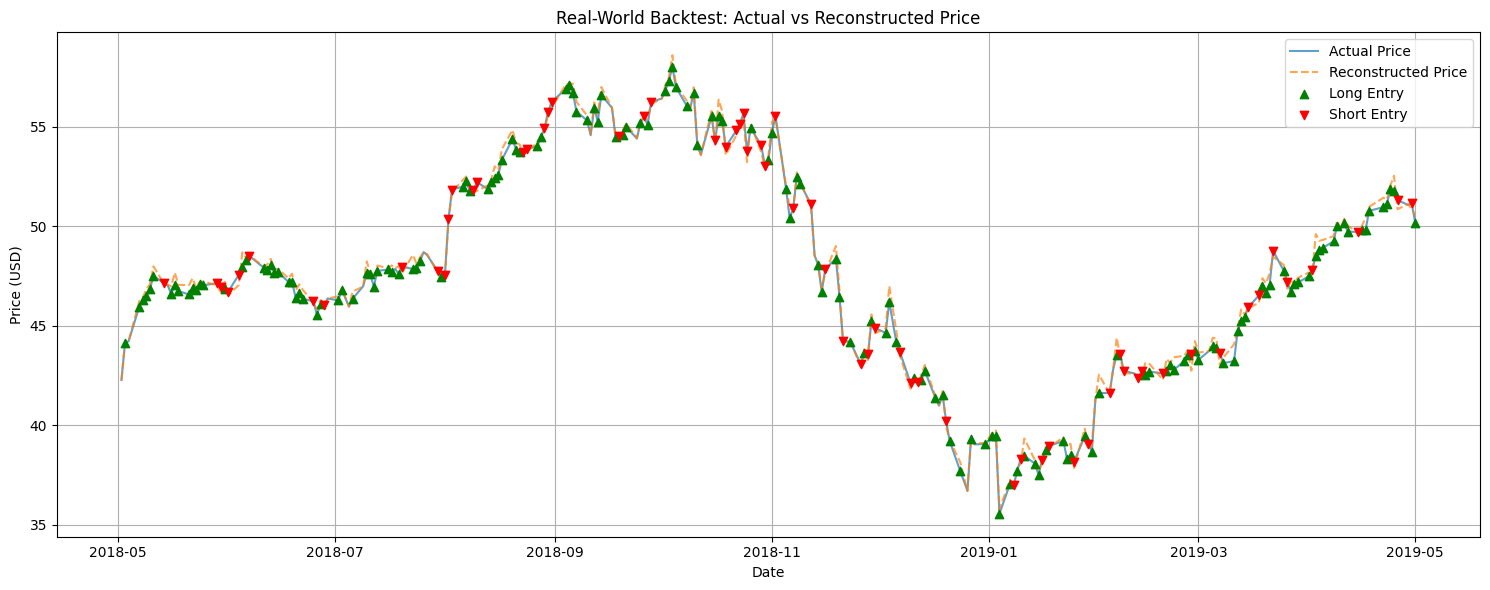

In [ ]:
result,_ = runner.run_real_world_simulation(MLP_Simulation, sim_config)

## Archive

In [11]:
# features = [
#     "Open", "High", "Low", "Close", "Volume",
#     "LogReturn_Lag1", "LogReturn_Lag2", "LogReturn_Lag3",
#     "LogReturn_Lag4", "LogReturn_Lag5"
# ]

# base_config_template = {
#     "csv_path": "stocks/AAPL.csv",
#     "features": features,
#     "target": "LogReturn",
#     "loader_func": load_data_with_logReturn
# }

# mlp_extra_config = {
#     "config": {
#         "window": 50,
#         "stride": 50,
#         "batch_size": 64,
#         "shuffle_train_set": False,
#         "lr": 1e-3,
#         "epochs": 20,
#         "dropout_rate": 0.2,
#         "device": device
#     }
# }

# sim_config = {
#     "csv_path": base_config_template["csv_path"],
#     "features": base_config_template["features"],
#     "target": base_config_template["target"],
#     "sim_start_date": "2019-05-01",
#     "sim_end_date": "2025-05-01",
#     "loader_func": base_config_template["loader_func"],
#     "window": 50,
#     "stride": 1,
#     "batch_size": 64,
#     "device": device
# }

# slide_start_dates = pd.date_range("1990-01-01", "2005-01-01", freq="5YS").strftime("%Y-%m-%d").tolist()

# for start in slide_start_dates:
#     start_year = int(start[:4])
#     end_year = start_year + 15
#     end = f"{end_year}-04-30" 

#     print(f"[INFO] Running experiment from {start} to {end}...")

#     base_config = {
#         **base_config_template,
#         "train_val_test_start": start,
#         "train_val_test_end": end,
#     }

#     mlp_config = {**base_config, **mlp_extra_config}

#     runner = BacktestRunner(MLP_Regression, mlp_config)
#     runner.train_optimal_model()
#     runner.evaluate_model()
#     runner.run_real_world_simulation(MLP_Simulation, sim_config)
#     runner.log_results(log_name=f"{start}_to_{end}")